In [1]:
import os
import pandas as pd
from omegaconf import OmegaConf
import matplotlib.pyplot as plt


config = OmegaConf.load("lstm_config.yaml")

In [2]:
def results_dataframe():
    """
    Lê e combina dados de múltiplos arquivos CSV em diferentes diretórios.
    
    Returns:
        DataFrame: Combina todos os CSVs encontrados com uma coluna adicional 'Model_covariates'
                  indicando o diretório de origem.
    """
    df_aux = pd.DataFrame()
    for directory in os.listdir(config.paths.eval_folder):
        for csv in os.listdir(config.paths.eval_folder+directory):
            df_temp = pd.read_csv(config.paths.eval_folder+directory+"/"+csv)
            df_temp['Model_covariates'] = directory
            df_aux = pd.concat([df_aux,df_temp])
    return df_aux

def house_result_variation_calculate(house,df_):
    """
    Calcula a variação das métricas de avaliação para uma casa específica em relação
    ao modelo base (#).
    
    Args:
        house: Identificador da casa a ser analisada
        
    Returns:
        DataFrame: Dados originais com colunas adicionais mostrando as variações das métricas
    """
    df_filtred = df_[df_.House_Hold == house]
    metrics_values = df_filtred[["MAE","SMAPE","RMSE"]].loc[df_filtred.Model_covariates == "#"]
    variation = df_filtred[["MAE","SMAPE","RMSE"]].sub(metrics_values)
    variation.rename(columns={a:b for a,b in zip(variation.columns,[x+"_variation" for x in variation.columns])},inplace=True)
    variation = pd.concat([df_filtred,variation],axis=1)
    return variation


def check_better_results(df_house_variation):
    """
    Analisa as variações e identifica onde houve melhorias nas métricas.
    Uma variação negativa indica melhoria em relação ao modelo base.
    Depois soma as colunas resumindo as variaveis booleanas

    Args:
        df_house_variation: DataFrame com as variações calculadas
        
    Returns:
        DataFrame: Sumário das melhorias por casa, onde para cada coluna apresenta a soma de quantas vezes uma covariavel adicionada ao modelo 
                   apresentou melhor desempenho que o modelo sem covariaveis
    """
    df_temp = df_house_variation
    for variation in df_temp.columns[-3:]:
        name_col = variation+"_bool"
        df_temp[name_col] = df_temp[variation].apply(lambda x : 1 if x < 0 else 0)
    df_better_results = df_temp[["House_Hold","MAE_variation_bool","SMAPE_variation_bool","RMSE_variation_bool"]].groupby("House_Hold").sum()
    df_better_results = df_better_results.reset_index()
    return df_better_results


def condense_results():
    """
    Função principal que coordena todo o processo de análise.
    Processa os dados de todas as casas e gera um relatório final
    mostrando onde houve melhorias nas métricas. 
    Salva em um csv.
    
    Returns:
        DataFrame: Resumo final das melhorias por casa
    """
    df_temp = results_dataframe()
    df_aux = pd.DataFrame()
    for house in df_temp.House_Hold.unique():
        a = house_result_variation_calculate(house,df_temp)
        b = check_better_results(a)
        df_aux = pd.concat([df_aux,b])
    df_aux.sort_values("MAE_variation_bool",ascending=False,inplace=True)
    df_aux.to_csv("resultados_condensados.csv")    
    return df_aux.sort_values("MAE_variation_bool",ascending=False)

In [3]:
condense_results()

,House_Hold,MAE_variation_bool,SMAPE_variation_bool,RMSE_variation_bool
0,STRETCHEDSOCIETY_BLOCK_97_MAC001314,6,6,3
0,ESTABLISHEDAFFLUENCE_BLOCK_28_MAC004895,6,6,6
0,ESTABLISHEDAFFLUENCE_BLOCK_23_MAC000164,6,2,6
0,ESTABLISHEDAFFLUENCE_BLOCK_39_MAC001651,6,6,6
0,ESTABLISHEDAFFLUENCE_BLOCK_13_MAC005411,6,5,3
...,...,...,...,...
0,STRETCHEDSOCIETY_BLOCK_93_MAC004547,0,0,0
0,STRETCHEDSOCIETY_BLOCK_99_MAC004799,0,0,0
0,STRETCHEDSOCIETY_BLOCK_104_MAC004481,0,1,3
0,ESTABLISHEDAFFLUENCE_BLOCK_10_MAC002036,0,2,0


In [17]:
df = results_dataframe()
df_auxiliar = pd.DataFrame()
for house in df.House_Hold.unique():
    a = house_result_variation_calculate(house,df)
    df_auxiliar = pd.concat([df_auxiliar,a])
df_auxiliar[~df_auxiliar.House_Hold.isin(df_auxiliar[df_auxiliar.MAE_variation.isnull()].House_Hold.unique())]

,House_Hold,MAE,MAPE,SMAPE,RMSE,Time_execution,Model_covariates,MAE_variation,SMAPE_variation,RMSE_variation
0,STRETCHEDSOCIETY_BLOCK_91_MAC001165,0.070,989939.440,1.058,0.150,265.43s,dayofweek_num,0.000,-0.044,-0.004
0,STRETCHEDSOCIETY_BLOCK_91_MAC001165,0.054,508220.470,0.975,0.130,265.51s,hour,-0.016,-0.127,-0.024
0,STRETCHEDSOCIETY_BLOCK_91_MAC001165,0.069,822453.440,1.084,0.152,301.24s,holiday,-0.001,-0.018,-0.002
0,STRETCHEDSOCIETY_BLOCK_91_MAC001165,0.070,990743.300,1.054,0.151,287.98s,precipType,0.000,-0.048,-0.003
0,STRETCHEDSOCIETY_BLOCK_91_MAC001165,0.075,1539828.800,1.043,0.147,260.72s,month,0.005,-0.059,-0.007
...,...,...,...,...,...,...,...,...,...,...
0,ESTABLISHEDAFFLUENCE_BLOCK_17_MAC002007,0.209,0.561,0.432,0.419,433.80s,precipType,0.027,-0.002,0.043
0,ESTABLISHEDAFFLUENCE_BLOCK_17_MAC002007,0.217,0.585,0.462,0.432,604.98s,month,0.035,0.028,0.056
0,ESTABLISHEDAFFLUENCE_BLOCK_17_MAC002007,0.182,0.676,0.434,0.376,526.26s,#,0.000,0.000,0.000
0,ESTABLISHEDAFFLUENCE_BLOCK_17_MAC002007,0.206,0.755,0.418,0.400,565.74s,bool_weather_missing_values,0.024,-0.016,0.024


In [4]:
def calculate_percentage_variation(house, df_):
   """
   Calcula a porcentagem de variação das métricas em relação ao modelo base.
   Args:
       house: Identificador da casa
       df_: DataFrame com os dados
   Returns:
       DataFrame: Dados com colunas de variação percentual 
   """
   # Aproveita função existente para obter variações
   df_variations = house_result_variation_calculate(house, df_)
   
   # Valores do modelo base
   base_values = df_variations[["MAE","SMAPE","RMSE"]].loc[df_variations.Model_covariates == "#"]
   pct_df = df_variations[["MAE","SMAPE","RMSE"]].div(base_values).sub(1).mul(100).round(2)
   pct_df.rename(columns={a:b for a,b in zip(pct_df.columns,[x+"_pct" for x in pct_df.columns])},inplace=True)
   pct_df = pd.concat([df_variations,pct_df],axis=1)
   return pct_df


In [37]:
df = results_dataframe()
df_auxiliar = pd.DataFrame()
for house in df.House_Hold.unique():
    a = calculate_percentage_variation(house,df)
    df_auxiliar = pd.concat([df_auxiliar,a])
df_auxiliar= df_auxiliar[~df_auxiliar.House_Hold.isin(df_auxiliar[df_auxiliar.MAE_variation.isnull()].House_Hold.unique())]
df_auxiliar[~df_auxiliar.House_Hold.isin(df_auxiliar[df_auxiliar.MAE_variation.isnull()].House_Hold.unique())].to_csv("pct_variacao.csv")
df_auxiliar = df_auxiliar[df_auxiliar.Model_covariates != "#"]

In [34]:
df_auxiliar[["House_Hold","MAE_pct","SMAPE_pct","RMSE_pct"]].groupby("House_Hold").mean().sort_values("MAE_pct",ascending=True).to_csv("media_variacao.csv")

In [2]:
import dtale
import dtale.global_state as global_state
global_state.set_app_settings(dict(enable_custom_filters=True))

df = pd.read_csv("pct_variacao.csv")
d = dtale.show(df)
d.kill()

# using Python's `webbrowser` package it will try and open your server's default browser to this process
d.open_browser()

Turning on custom filtering. Custom filters are vulnerable to code injection attacks, please only use in trusted environments.
2024-11-18 08:48:17,779 - WARNING  - Custom filtering enabled. Custom filters are vulnerable to code injection attacks, please only use in trusted environments.
2024-11-18 08:48:17,803 - INFO     - Shutdown complete


In [41]:
df = pd.read_csv("pct_variacao.csv")

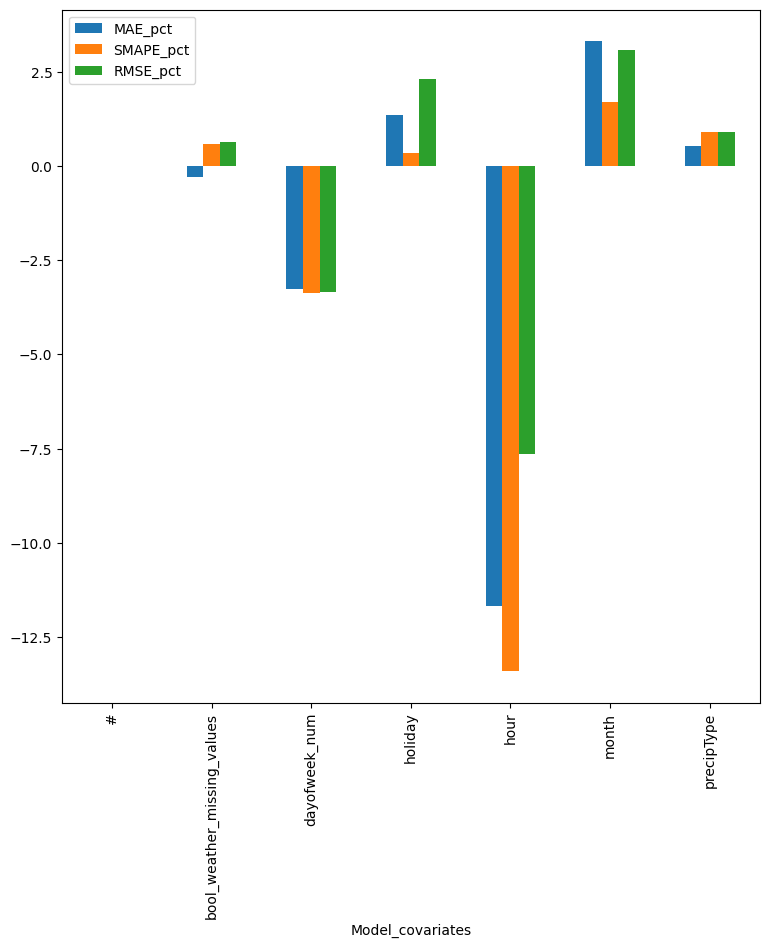

In [53]:
df[["Model_covariates","MAE_pct","SMAPE_pct","RMSE_pct"]].groupby("Model_covariates").mean().plot(kind="bar",figsize = (9,9))
plt.show()

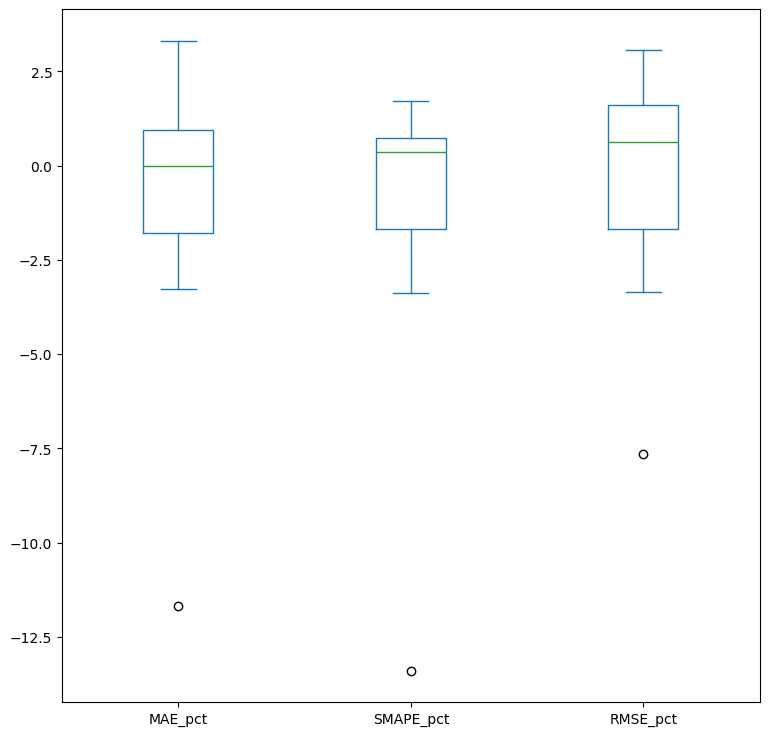

In [56]:
df[["Model_covariates","MAE_pct","SMAPE_pct","RMSE_pct"]].groupby("Model_covariates").mean().plot(kind="box",figsize = (9,9))
plt.show()